In [ ]:
!pip install investpy==1.0.6

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
!pip install arch==4.19

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
import pandas as pd
import investpy
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy.stats as stats
import pylab
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

In [ ]:
DJ = investpy.get_index_historical_data(index='DJ Life Insurance',
                                        country='United States',
                                        from_date='01/04/2011',
                                        to_date='01/04/2021')
AEX = investpy.get_index_historical_data(index='AEX',
                                        country='Netherlands',
                                        from_date='01/04/2011',
                                        to_date='01/04/2021')
SP500=investpy.get_index_historical_data(index='s&p 500',
                                    country='United States',
                                    from_date='01/04/2011',
                                    to_date='01/04/2021')
euro_usd = investpy.get_currency_cross_historical_data(currency_cross='EUR/USD',
                                                    from_date='01/04/2011',
                                                    to_date='01/04/2021')
bond=investpy.get_bond_historical_data('Netherlands 3Y',
                                    from_date='01/04/2011',
                                    to_date='01/04/2021')
data=pd.DataFrame({'DJ':DJ.Close,'SP500':SP500.Close,'AEX':AEX.Close,'bond':bond.Close,'euro_usd':euro_usd.Close})
data=data.dropna() # synchronize

In [ ]:
data['DJ']=data['DJ']/data['euro_usd']
data['SP500']=data['SP500']/data['euro_usd']

In [ ]:
data

,DJ,SP500,AEX,bond,euro_usd
Date,,,,,
2011-04-01,345.464128,936.272925,369.45,2.208,1.4231
2011-04-04,348.586697,937.188862,369.01,2.203,1.4222
2011-04-05,346.220910,936.954229,368.96,2.199,1.4223
2011-04-06,347.729017,931.793763,369.64,2.214,1.4333
2011-04-07,345.155201,932.263702,367.39,2.211,1.4304
...,...,...,...,...,...
2021-03-26,729.103086,3369.396406,696.62,-0.714,1.1796
2021-03-29,723.193334,3376.203027,697.94,-0.704,1.1762
2021-03-30,738.543623,3379.332423,701.12,-0.685,1.1714


In [ ]:
# Log return
L=pd.DataFrame(columns=['DJ','SP500','AEX','bond'])
L['DJ']=np.log(data['DJ']).diff() # log return
L['SP500']=np.log(data['SP500']).diff()
L['AEX']=np.log(data['AEX']).diff()
L['bond']=data['bond'].diff() 
L['bond']=L['bond']/100 #change yield
L['y']=data['bond']
L=L.dropna() # remove first row
# compute everyday portfolio loss, last column
L['loss']=L.apply(lambda r: 0.25*(1-np.exp(r.DJ))+\
                            0.25*(1-np.exp(r.SP500))+\
                            0.25*(1-np.exp(r.AEX))\
                           -0.25*(1-np.exp(-r.bond))+\
                            0.25*r.y / 25000,
                            axis=1) # without time to maturity
L

,DJ,SP500,AEX,bond,y,loss
Date,,,,,,
2011-04-04,0.008998,0.000978,-0.001192,-0.00005,2.203,-0.002172
2011-04-05,-0.006810,-0.000250,-0.000136,-0.00004,2.199,0.001825
2011-04-06,0.004346,-0.005523,0.001841,0.00015,2.214,-0.000188
2011-04-07,-0.007429,0.000504,-0.006106,-0.00003,2.211,0.003276
2011-04-08,-0.025490,-0.016311,-0.001226,0.00083,2.294,0.010458
...,...,...,...,...,...,...
2021-03-26,0.008567,0.013778,0.016340,0.00004,-0.714,-0.009755
2021-03-29,-0.008139,0.002018,0.001893,0.00010,-0.704,0.001016
2021-03-30,0.021004,0.000926,0.004546,0.00019,-0.685,-0.006732


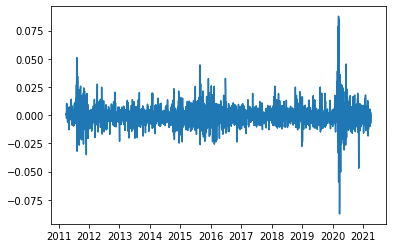

In [ ]:
plt.plot(L.loss)

In [ ]:
# GARCH function
def garch(L, window_size=750, step=1742, investment=1000000):
    # step is how many steps totally moved, len(data)-window_size
    pred_vars=pd.DataFrame(index=L.index)
    for asset in L.columns[:4]:
        am = arch_model(L[asset], vol="Garch", p=1, o=0, q=1, dist="Normal")
        forecasts = {}
        for i in range(step):
            res = am.fit(first_obs=i, last_obs=i + window_size, disp="off")
            temp = res.forecast(horizon=1, reindex=False).variance
            #print(i,'temp',temp.shape)
            fcast = temp.iloc[0]
            #print(i,'fcast',fcast)
            forecasts[fcast.name] = fcast
        var=pd.DataFrame(forecasts).T
        pred_vars[asset]=var
    pred_vars=pred_vars.dropna()
    sigma=np.sqrt(pred_vars) 
    weights = np.array([0.25,0.25,0.25,0.25]) # default
    cov=np.zeros([4,4])
    VaRs975, ESs975, VaRs99, ESs99=[],[],[],[]
    corr_matrix= L.iloc[:,:4].corr()
    for i in range(window_size,window_size+step):
        mean_loss= np.mean(L.loss[:i]) 
        # update cov matrix
        for r in range(corr_matrix.shape[0]):
            for c in range(corr_matrix.shape[1]):
                cov[r][c]=corr_matrix.to_numpy()[r][c]*sigma.to_numpy()[i-window_size][r]*sigma.to_numpy()[i-window_size][c]
        port_std=np.sqrt(weights.T.dot(cov).dot(weights))
        VaRs975.append((mean_loss+ port_std* norm.ppf(0.975))*investment) # calculate VaR here
        ESs975.append((mean_loss + port_std* norm.pdf(norm.ppf(0.975))/(1-0.975))*investment)
        VaRs99.append((mean_loss+ port_std* norm.ppf(0.99))*investment) # calculate VaR here
        ESs99.append((mean_loss + port_std* norm.pdf(norm.ppf(0.99))/(1-0.99))*investment)
    #result=pd.DataFrame([VaRs,ESs],columns=['VaR{}'.format(CI),'ES{}'.format(CI)],index= L.index[window_size:]) # transform to a dataframe
    result=pd.DataFrame(index= L.index[window_size:]) # transform to a dataframe
    result['VaR_975']=VaRs975
    result['ES_975']=ESs975
    result['VaR_99']=VaRs99
    result['ES_99']=ESs99
    return result 

In [ ]:
garchresult=garch(L)

Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/root/venv/lib/python3.7/site-packages/arch/univariate/base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/root/venv/lib/python3.7/site-packages/arch/univariate/base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/root/venv/lib/python3.7/site-packages/arch/univariate/base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/root/venv/lib/python3.7/site-packages/arch/univariate/base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompati

In [ ]:
garchresult

,VaR_975,ES_975,VaR_99,ES_99
Date,,,,
2014-04-08,13775.550342,16488.710318,16406.455597,18839.764694
2014-04-09,13413.070789,16056.023939,15975.897675,18346.241482
2014-04-10,13183.194805,15782.823665,15704.010861,18035.499092
2014-04-11,15230.398506,18220.727491,18130.069853,20811.959158
2014-04-14,15547.148260,18595.476137,18503.060150,21236.966010
...,...,...,...,...
2021-03-26,14616.999487,17500.156088,17412.747589,19998.518885
2021-03-29,14981.514689,17935.671556,17846.110546,20495.558733
2021-03-30,14111.750947,16898.130919,16813.656392,19312.633155


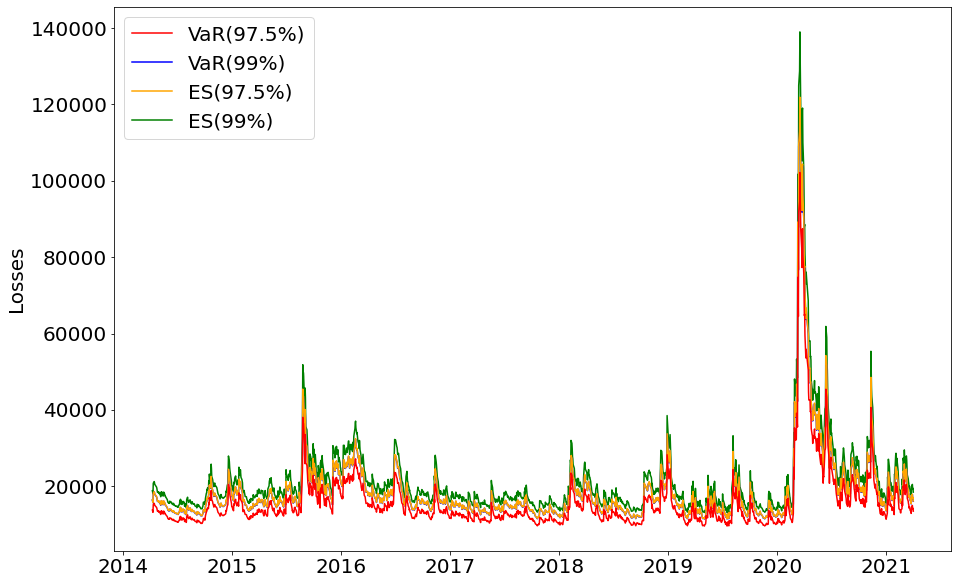

In [ ]:
plt.figure(figsize=(15,10))
#plt.plot(L.loss[750:]*1000000,label='Loss',color='lightgray',zorder=1)
plt.plot(garchresult['VaR_975'],c='red',label='VaR(97.5%)',zorder=4)
plt.plot(garchresult['VaR_99'],c='blue',label='VaR(99%)',zorder=2)
plt.plot(garchresult['ES_975'],c='orange',label='ES(97.5%)',zorder=3)
plt.plot(garchresult['ES_99'],c='green',label='ES(99%)',zorder=1)
plt.ylabel('Losses',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', prop={'size': 20})
plt.savefig('garch result',dpi=400)
plt.show()

In [ ]:
def cal_VaR_ES(returns,CI=0.975,method='normal',df=3):
    weights = np.array([0.25, 0.25, 0.25, 0.25])
    initial_investment = 1000000
    avg_rets = returns.mean()
    cov_matrix = returns.cov()
    port_mean = avg_rets.dot(weights) 
    port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
    if method=='normal':
            VaR=(-port_mean + norm.ppf(CI)*port_stdev)*initial_investment
            #print('VaR',VaR)
            ES=(-port_mean + port_stdev*norm.pdf(norm.ppf(CI))/(1-CI))*initial_investment
            #print('ES',ES)

    elif method=='student':
            t_std= np.sqrt((df-2)/df)*port_stdev
            VaR=(-port_mean+ stats.t.ppf(CI,df)*t_std)*initial_investment
            #print('VaR',VaR)
            ES=(-port_mean + t_std*stats.t.pdf(x=stats.t.ppf(CI,df=df),df=df)/(1-CI)*((df+stats.t.ppf(CI, df)**2)/(df-1)))*initial_investment
            #print('ES',ES)

    return VaR, ES

In [ ]:
def vc_roll(returns,k, method='normal',step=1): # k-window length step-step size
    result = pd.DataFrame(columns=['VaR_975','VaR_99','ES_975','ES_99'])
    result['VaR_975']=returns['SP500']
    if method=='normal':
        for i in range(0, len(result)-k,step): # window step=250
            VaR1, ES1 = cal_VaR_ES(returns[i:i+k],CI=0.975,method='normal')
            result['VaR_975'][i+k-step:i+k]=VaR1
            result['ES_975'][i+k-step:i+k]=ES1
            VaR2, ES2 = cal_VaR_ES(returns[i:i+k],CI=0.99,method='normal')
            result['VaR_99'][i+k-step:i+k]=VaR2
            result['ES_99'][i+k-step:i+k]=ES2
    if method=='student':
        for i in range(0, len(result)-k,step): # window step=1
            VaR1, ES1 = cal_VaR_ES(returns[i:i+k],CI=0.975,method='student',df=3) #default degree
            result['VaR_975'][i+k-step:i+k]=VaR1
            result['ES_975'][i+k-step:i+k]=ES1
            VaR2, ES2 = cal_VaR_ES(returns[i:i+k],CI=0.99,method='student',df=3)
            result['VaR_99'][i+k-step:i+k]=VaR2
            result['ES_99'][i+k-step:i+k]=ES2
    return result.dropna()

In [ ]:
def hs_roll(returns,k,step=1): # k-window length step-window step
    result = pd.DataFrame(columns=['VaR_975','VaR_99','ES_975','ES_99'])
    result['VaR_975']=returns[:]*1000000
    for i in range(0, len(result)-k,step): 
        temp = returns[i:i+k]*1000000
        result['VaR_975'][i+k-step:i+k]= temp.quantile(q=0.975)
        result['ES_975'][i+k-step:i+k]= temp[temp >= temp.quantile(0.975)].mean()
        result['VaR_99'][i+k-step:i+k]=temp.quantile(q=0.99)
        result['ES_99'][i+k-step:i+k]= temp[temp >= temp.quantile(0.99)].mean()
    return result.dropna()

In [ ]:
vc_roll_daily = vc_roll(L.iloc[:,:4],750,method='normal',step=1)
vc_roll_daily

,VaR_975,VaR_99,ES_975,ES_99
Date,,,,
2014-04-07,15932.999178,18957.225008,19051.776817,21754.314037
2014-04-08,15936.857563,18961.016123,19055.565828,21758.042933
2014-04-09,15930.660864,18955.146731,19049.706669,21752.476265
2014-04-10,15989.973897,19021.666471,19116.451726,21825.661447
2014-04-11,16022.270953,19057.873687,19152.781192,21865.485148
...,...,...,...,...
2021-03-25,22801.123982,27108.639417,27243.313016,31092.6356
2021-03-26,22742.384801,27045.564229,27180.102263,31025.550063
2021-03-29,22674.874802,26970.011878,27104.298469,30942.559388


In [ ]:
vc_roll_stu_daily = vc_roll(L.iloc[:,:4],750,method='student',step=1)
vc_roll_stu_daily

,VaR_975,VaR_99,ES_975,ES_99
Date,,,,
2014-04-07,14921.211218,21394.113211,23771.574707,33128.81756
2014-04-08,14925.092109,21397.85012,23775.258731,33132.293444
2014-04-09,14918.785905,21392.244468,23769.910389,33127.95782
2014-04-10,14975.687856,21464.571294,23847.902687,33228.248356
2014-04-11,15006.676725,21503.929275,23890.334597,33282.778675
...,...,...,...,...
2021-03-25,21359.997392,30579.588393,33965.893737,47293.756896
2021-03-26,21302.708870,30513.019297,33895.915936,47210.363073
2021-03-29,21237.889528,30430.986507,33807.560741,47097.124078


In [ ]:
hs_roll_daily=hs_roll(L.loss, 750, step=1)
hs_roll_daily

,VaR_975,VaR_99,ES_975,ES_99
Date,,,,
2014-04-07,15896.458496,23511.162879,24605.974533,31220.332182
2014-04-08,15896.458496,23511.162879,24605.974533,31220.332182
2014-04-09,15896.458496,23511.162879,24605.974533,31220.332182
2014-04-10,15896.458496,23511.162879,24605.974533,31220.332182
2014-04-11,15896.458496,23511.162879,24605.974533,31220.332182
...,...,...,...,...
2021-03-25,22796.712255,30891.811364,38410.449291,55444.757125
2021-03-26,22796.712255,30891.811364,38410.449291,55444.757125
2021-03-29,22796.712255,30891.811364,38410.449291,55444.757125


In [ ]:
def filter_hist(stock,df):
    lambda_hist=0.94
    result = pd.DataFrame(columns = [stock,'variance','vola'])
    result[stock]=df[stock]
    result['variance'][0]=0
    result['variance'][1]=result[stock][1]**2
    result['vola'][1] = result[stock][1]
    
    for i in np.arange(2,len(result),1):
        result['variance'][i] = lambda_hist * (result['vola'][i-1]**2) + (1-lambda_hist)*(result[stock][i-1]**2)
        result['vola'][i] = np.sqrt(result['variance'][i])
    result['variance'][1]=result[stock][1]**2
    
    result['vola'][1]= np.sqrt(result['variance'][1])
    result['riskfactor'] = result[stock]/result['vola']
    return result.dropna()

def filter_simulation(df,k):
    djresult=filter_hist('DJ',df)
    spresult=filter_hist('SP500',df)
    aexresult=filter_hist('AEX',df)
    bondresult=filter_hist('bond',df)
    
    portfolio = pd.DataFrame(columns = ['port'])
    portfolio['port'] = np.arange(0,len(bondresult),1)
    portfolio['VaR_975'] = np.arange(0,len(bondresult),1)
    portfolio['VaR_99'] = np.arange(0,len(bondresult),1)
    portfolio['ES_99'] = np.arange(0,len(bondresult),1)
    portfolio['ES_975'] = np.arange(0,len(bondresult),1)
    portfolio.index =djresult.index
    
    for i in range(0,len(djresult)-k,1):
        djresult_value_risk = djresult['vola'][i+k]*djresult['riskfactor'][i:i+k]*0.25
        spresult_value_risk = spresult['vola'][i+k]*spresult['riskfactor'][i:i+k]*0.25
        aexresult_value_risk = aexresult['vola'][i+k]*aexresult['riskfactor'][i:i+k]*0.25
        bondresult_value_risk = bondresult['vola'][i+k]*bondresult['riskfactor'][i:i+k]*0.25
        
        value_risk = djresult_value_risk+spresult_value_risk +aexresult_value_risk +bondresult_value_risk
        
        portfolio.VaR_975[i+k:i+k+1] = value_risk.quantile(0.975)*1000000
        portfolio.VaR_99[i+k:i+k+1] = value_risk.quantile(0.99)*1000000
        portfolio.ES_975[i+k:i+k+1] =  value_risk[value_risk >= value_risk.quantile(0.975)].mean()*1000000
        portfolio.ES_99[i+k:i+k+1] =  value_risk[value_risk >= value_risk.quantile(0.99)].mean()*1000000
    return portfolio[k:]

In [ ]:
fhs_roll_daily = filter_simulation(L.iloc[:,:4],k=750)
fhs_roll_daily

,port,VaR_975,VaR_99,ES_99,ES_975
Date,,,,,
2014-04-09,750,11986.339932,18025.985761,19805.772926,16907.500515
2014-04-10,751,11801.938315,17743.207051,19467.255532,16619.334973
2014-04-11,752,13991.055634,20949.934100,22690.967365,19282.455408
2014-04-14,753,14434.309978,21623.789406,23535.865981,20032.188472
2014-04-15,754,14408.671552,21627.751844,23418.261063,19927.255884
...,...,...,...,...,...
2021-03-26,2486,13132.489677,16483.271119,20262.322639,17170.945853
2021-03-29,2487,13299.666497,16692.037876,20366.422611,17348.516716
2021-03-30,2488,12953.286226,16254.874265,19849.990480,16900.878465


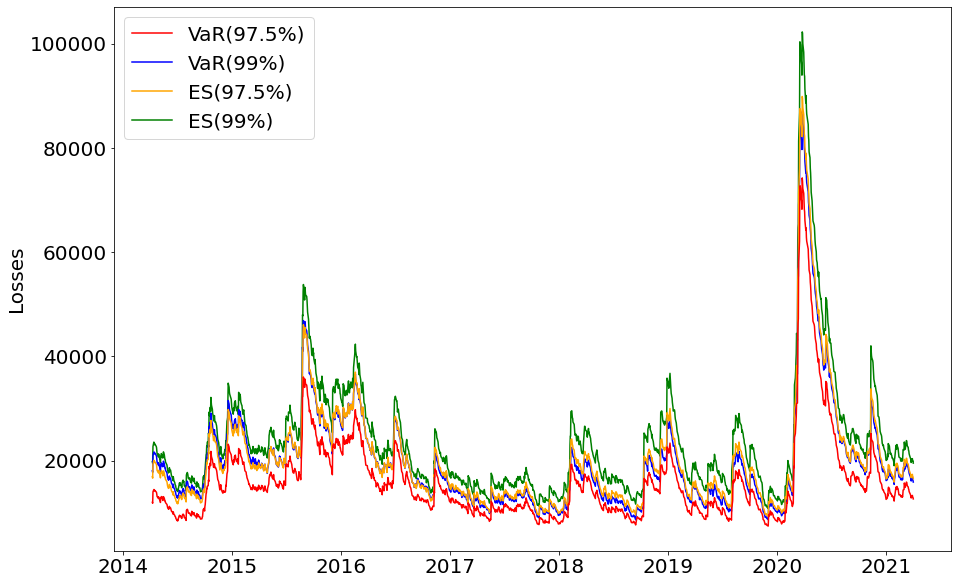

In [ ]:
plt.figure(figsize=(15,10))
#plt.plot(L.loss[750:]*1000000,label='Loss',color='lightgray',zorder=1)
plt.plot(fhs_roll_daily['VaR_975'],c='red',label='VaR(97.5%)',zorder=4)
plt.plot(fhs_roll_daily['VaR_99'],c='blue',label='VaR(99%)',zorder=2)
plt.plot(fhs_roll_daily['ES_975'],c='orange',label='ES(97.5%)',zorder=3)
plt.plot(fhs_roll_daily['ES_99'],c='green',label='ES(99%)',zorder=1)
plt.ylabel('Losses',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', prop={'size': 20})
plt.savefig('fhs result',dpi=400)
plt.show()

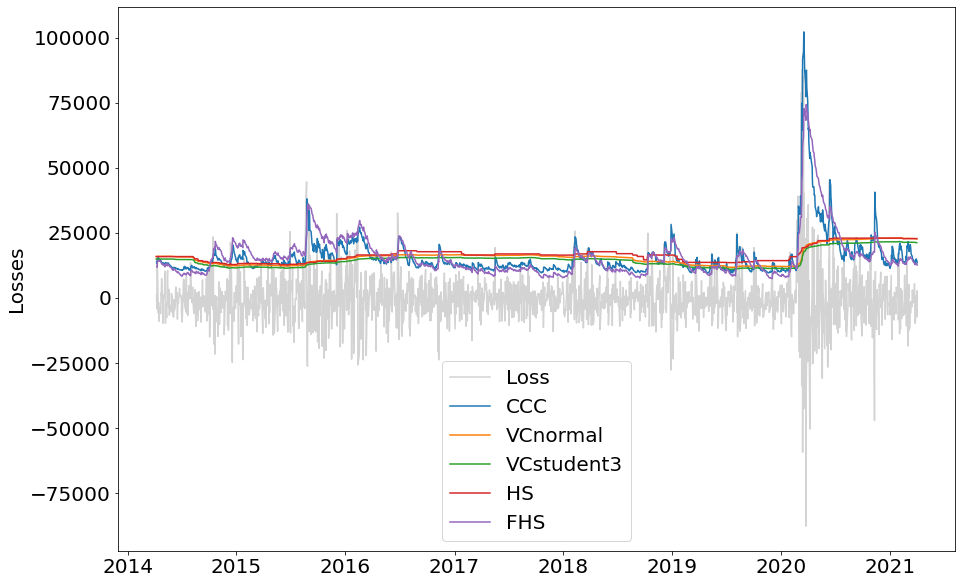

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(L.loss[750:]*1000000,label='Loss',color='lightgray',zorder=1)
plt.plot(garchresult['VaR_975'],label='CCC',zorder=2)
plt.plot(vc_roll_daily['VaR_975'],label='VCnormal',zorder=3)
plt.plot(vc_roll_stu_daily['VaR_975'],label='VCstudent3',zorder=4)
plt.plot(hs_roll_daily['VaR_975'],label='HS',zorder=5)
plt.plot(fhs_roll_daily['VaR_975'],label='FHS',zorder=6)
plt.ylabel('Losses',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', prop={'size': 20})
plt.savefig('five method',dpi=400)
plt.show()

In [ ]:
Loss_dist=L.loss[750:]*1000000
Loss_dist[0:1741]

Date
2014-04-08      981.608107
2014-04-09    -4161.856534
2014-04-10    15152.839319
2014-04-11    11701.217931
2014-04-14    -5857.195125
                  ...     
2021-03-25    -9182.004498
2021-03-26    -9754.926282
2021-03-29     1015.589779
2021-03-30    -6731.562709
2021-03-31     2774.280522
Name: loss, Length: 1741, dtype: float64

In [ ]:
# VC_normal violation per year- 97.5%
Loss_dist=L.loss[750:]*1000000 #2014-4-8/2021-4-1
vc_norm_violation=[]
for i in range(0,int(len(Loss_dist)/250)):
    bool_list = [Loss_dist[j]>vc_roll_daily['VaR_975'][j+1] for j in range(i*250,(i+1)*250)]
    index = np.where(bool_list)[0]
    count = len(index)
    #print(i,":",count)
    vc_norm_violation.append(count)
bool_list = [Loss_dist[j]>vc_roll_daily['VaR_975'][j+1] for j in range(1500,1741)]
index = np.where(bool_list)[0]
count = len(index)
vc_norm_violation.append(count)
print(vc_norm_violation)

[8, 22, 3, 6, 10, 30, 5]


In [ ]:
stats.binom_test(np.sum(vc_norm_violation),n=1741,p=0.025)

3.349081552608627e-08

In [ ]:
# VC_normal violation per year- 99%
Loss_dist=L.loss[750:]*1000000 #2014-4-8/2021-4-1
vc_norm_violation=[]
for i in range(0,int(len(Loss_dist)/250)):
    bool_list = [Loss_dist[j]>vc_roll_daily['VaR_99'][j+1] for j in range(i*250,(i+1)*250)]
    index = np.where(bool_list)[0]
    count = len(index)
    #print(i,":",count)
    vc_norm_violation.append(count)
bool_list = [Loss_dist[j]>vc_roll_daily['VaR_99'][j+1] for j in range(1500,1741)]
index = np.where(bool_list)[0]
count = len(index)
vc_norm_violation.append(count)
print(vc_norm_violation)

[3, 12, 2, 2, 5, 23, 2]


In [ ]:
stats.binom_test(np.sum(vc_norm_violation),n=1741,p=0.01)

3.258917292607809e-10

In [ ]:
vc_norm_es_true=[]
vc_norm_es_esti=[]
for i in range(0,int(len(Loss_dist)/250)):
    true_ES= np.mean(Loss_dist[i*250:(i+1)*250][Loss_dist[i*250:(i+1)*250]>vc_roll_daily.VaR_975[1+i*250:1+(i+1)*250]])
    vc_norm_es_true.append(true_ES)
    estimate_ES= np.mean(vc_roll_daily.ES_975[1+i*250:1+(i+1)*250])
    vc_norm_es_esti.append(estimate_ES)
true_ES= np.mean(Loss_dist[1500:1741][Loss_dist[1500:1741]>vc_roll_daily.VaR_975[1501:1742]])
vc_norm_es_true.append(true_ES)
estimate_ES= np.mean(vc_roll_daily.ES_975[1501:1742])
vc_norm_es_esti.append(estimate_ES)
print(vc_norm_es_true)
print(vc_norm_es_esti)

[15976.379362598327, 21466.272824572967, 24058.88276838216, 19729.720890032408, 17570.832545744775, 28344.72294692851, 28134.025616112376]
[16743.990966007124, 16836.265244478687, 19676.81441720121, 19357.981454166445, 17207.47959899113, 15515.4815586735, 26863.979104631897]


In [ ]:
stats.kstest(vc_norm_es_true,vc_norm_es_esti)

KstestResult(statistic=0.5714285714285714, pvalue=0.21212121212121213)

In [ ]:
vc_norm_es_true=[]
vc_norm_es_esti=[]
for i in range(0,int(len(Loss_dist)/250)):
    true_ES= np.mean(Loss_dist[i*250:(i+1)*250][Loss_dist[i*250:(i+1)*250]>vc_roll_daily.VaR_99[1+i*250:1+(i+1)*250]])
    vc_norm_es_true.append(true_ES)
    estimate_ES= np.mean(vc_roll_daily.ES_99[1+i*250:1+(i+1)*250])
    vc_norm_es_esti.append(estimate_ES)
true_ES= np.mean(Loss_dist[1500:1741][Loss_dist[1500:1741]>vc_roll_daily.VaR_99[1501:1742]])
vc_norm_es_true.append(true_ES)
estimate_ES= np.mean(vc_roll_daily.ES_99[1501:1742])
vc_norm_es_esti.append(estimate_ES)
print(vc_norm_es_true)
print(vc_norm_es_esti)

[20179.71931544906, 26426.998396207175, 27254.444684092778, 23341.999385124196, 20598.506136623197, 32484.119413092914, 35857.20286718878]
[19153.54022345624, 19260.000383599956, 22477.5891564558, 22108.07025301586, 19644.08731991213, 17715.144702497695, 30633.241558168967]


In [ ]:
stats.kstest(vc_norm_es_true,vc_norm_es_esti)

KstestResult(statistic=0.5714285714285714, pvalue=0.21212121212121213)

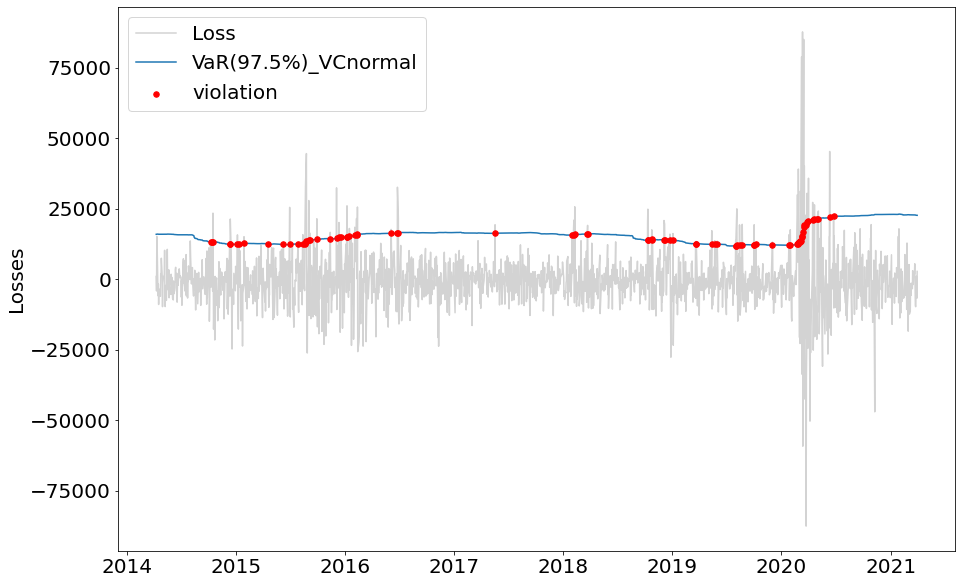

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(Loss_dist[0:1741],label='Loss',color='lightgray', zorder=1) #2014-4-8/2021-3-31
plt.plot(vc_roll_daily['VaR_975'][1:1742],label='VaR(97.5%)_VCnormal', zorder=2)
plt.scatter(vc_roll_daily.VaR_975[1:1742][Loss_dist[0:1741]>vc_roll_daily.VaR_975[1:1742]].index,
            vc_roll_daily.VaR_975[1:1742][Loss_dist[0:1741]>vc_roll_daily.VaR_975[1:1742]].values,
            marker='o',c='r',s=30, label='violation', zorder=3)
plt.ylabel('Losses',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', prop={'size': 20})
plt.savefig('Violation_VC_normal_975',dpi=400)
plt.show()

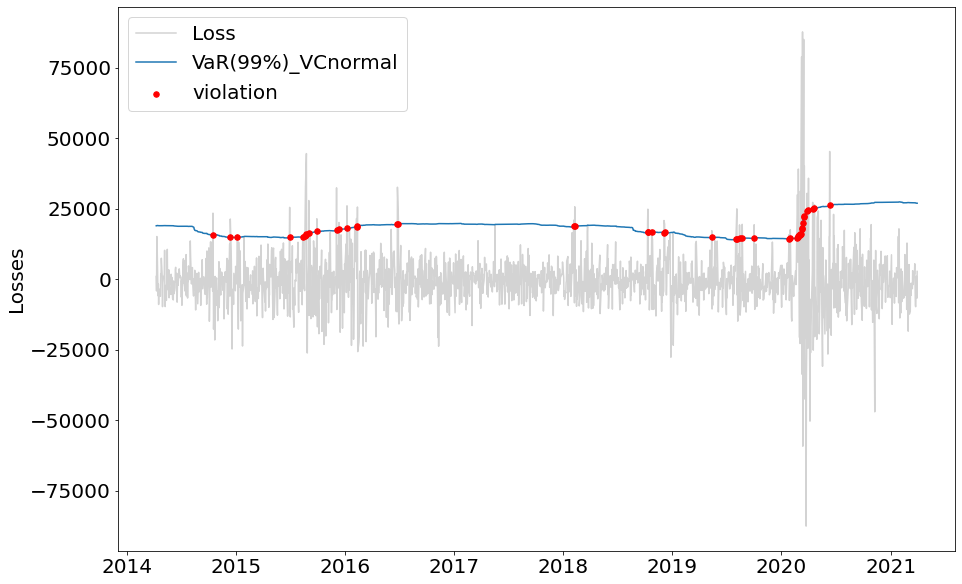

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(Loss_dist[0:1741],label='Loss',color='lightgray', zorder=1) #2014-4-8/2021-3-31
plt.plot(vc_roll_daily['VaR_99'][1:1742],label='VaR(99%)_VCnormal', zorder=2)
plt.scatter(vc_roll_daily.VaR_99[1:1742][Loss_dist[0:1741]>vc_roll_daily.VaR_99[1:1742]].index,
            vc_roll_daily.VaR_99[1:1742][Loss_dist[0:1741]>vc_roll_daily.VaR_99[1:1742]].values,
            marker='o',c='r',s=30, label='violation', zorder=3)
plt.ylabel('Losses',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', prop={'size': 20})
plt.savefig('Violation_VC_normal_99',dpi=400)
plt.show()

In [ ]:
# VC_student violation per year-97.5%
Loss_dist=L.loss[750:]*1000000 #2014-4-8/2021-4-1
vc_stu_violation=[]
for i in range(0,int(len(Loss_dist)/250)):
    bool_list = [Loss_dist[j]>vc_roll_stu_daily['VaR_975'][j+1] for j in range(i*250,(i+1)*250)]
    index = np.where(bool_list)[0]
    count = len(index)
    #print(i,":",count)
    vc_stu_violation.append(count)
bool_list = [Loss_dist[j]>vc_roll_stu_daily['VaR_975'][j+1] for j in range(1500,1741)]
index = np.where(bool_list)[0]
count = len(index)
vc_stu_violation.append(count)
print(vc_stu_violation)

[10, 24, 3, 6, 11, 31, 6]


In [ ]:
stats.binom_test(np.sum(vc_stu_violation),n=1741,p=0.025)

1.5278769230210477e-10

In [ ]:
# VC_student violation per year-99%
Loss_dist=L.loss[750:]*1000000 #2014-4-8/2021-4-1
vc_stu_violation=[]
for i in range(0,int(len(Loss_dist)/250)):
    bool_list = [Loss_dist[j]>vc_roll_stu_daily['VaR_99'][j+1] for j in range(i*250,(i+1)*250)]
    index = np.where(bool_list)[0]
    count = len(index)
    #print(i,":",count)
    vc_stu_violation.append(count)
bool_list = [Loss_dist[j]>vc_roll_stu_daily['VaR_99'][j+1] for j in range(1500,1741)]
index = np.where(bool_list)[0]
count = len(index)
vc_stu_violation.append(count)
print(vc_stu_violation)

[2, 11, 1, 1, 4, 19, 1]


In [ ]:
stats.binom_test(np.sum(vc_stu_violation),n=1741,p=0.01)

5.535605588474095e-06

In [ ]:
vc_stu_es_true=[]
vc_stu_es_esti=[]
for i in range(0,int(len(Loss_dist)/250)):
    true_ES= np.mean(Loss_dist[i*250:(i+1)*250][Loss_dist[i*250:(i+1)*250]>vc_roll_stu_daily.VaR_975[1+i*250:1+(i+1)*250]])
    vc_stu_es_true.append(true_ES)
    estimate_ES= np.mean(vc_roll_stu_daily.ES_975[1+i*250:1+(i+1)*250])
    vc_stu_es_esti.append(estimate_ES)
true_ES= np.mean(Loss_dist[1500:1741][Loss_dist[1500:1741]>vc_roll_stu_daily.VaR_975[1501:1742]])
vc_stu_es_true.append(true_ES)
estimate_ES= np.mean(vc_roll_stu_daily.ES_975[1501:1742])
vc_stu_es_esti.append(estimate_ES)
print(vc_stu_es_true)
print(vc_stu_es_esti)

[15508.79980346993, 20738.627389464757, 24058.88276838216, 19729.720890032408, 17218.283593368364, 28016.229452541163, 26931.37244765673]
[20952.105258773903, 21069.154217088846, 24568.177469706206, 24160.82495074124, 21462.849662323428, 19357.043994545118, 33446.7402392644]


In [ ]:
stats.kstest(vc_stu_es_true,vc_stu_es_esti)

KstestResult(statistic=0.42857142857142855, pvalue=0.5751748251748252)

In [ ]:
vc_stu_es_true=[]
vc_stu_es_esti=[]
for i in range(0,int(len(Loss_dist)/250)):
    true_ES= np.mean(Loss_dist[i*250:(i+1)*250][Loss_dist[i*250:(i+1)*250]>vc_roll_stu_daily.VaR_99[1+i*250:1+(i+1)*250]])
    vc_stu_es_true.append(true_ES)
    estimate_ES= np.mean(vc_roll_stu_daily.ES_99[1+i*250:1+(i+1)*250])
    vc_stu_es_esti.append(estimate_ES)
true_ES= np.mean(Loss_dist[1500:1741][Loss_dist[1500:1741]>vc_roll_stu_daily.VaR_99[1501:1742]])
vc_stu_es_true.append(true_ES)
estimate_ES= np.mean(vc_roll_stu_daily.ES_99[1501:1742])
vc_stu_es_esti.append(estimate_ES)
print(vc_stu_es_true)
print(vc_stu_es_esti)

[22404.092219425154, 27392.995090230834, 32638.226610469854, 25710.80674262765, 21367.09963872451, 35399.000316976344, 45332.17629613117]
[29294.90897905232, 29461.07501850776, 34265.557111179995, 33682.710005054854, 29899.340386102827, 26973.13974478665, 46497.4038531578]


In [ ]:
stats.kstest(vc_stu_es_true,vc_stu_es_esti)

KstestResult(statistic=0.42857142857142855, pvalue=0.5751748251748252)

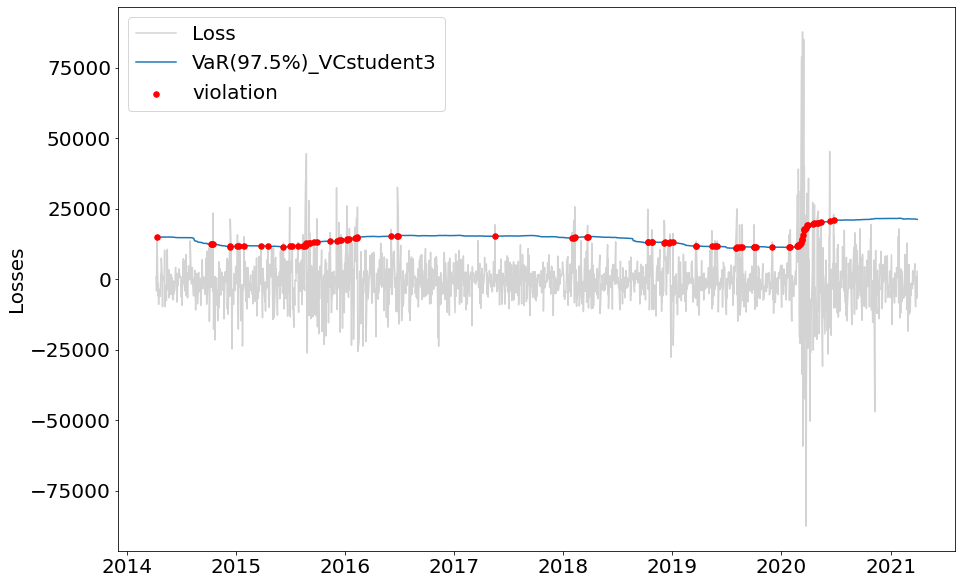

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(Loss_dist[0:1741],label='Loss',color='lightgray', zorder=1) #2014-4-8/2021-3-31
plt.plot(vc_roll_stu_daily['VaR_975'][1:1742],label='VaR(97.5%)_VCstudent3', zorder=2)
plt.scatter(vc_roll_stu_daily.VaR_975[1:1742][Loss_dist[0:1741]>vc_roll_stu_daily.VaR_975[1:1742]].index,
            vc_roll_stu_daily.VaR_975[1:1742][Loss_dist[0:1741]>vc_roll_stu_daily.VaR_975[1:1742]].values,
            marker='o',c='r',s=30, label='violation', zorder=3)
plt.ylabel('Losses',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', prop={'size': 20})
plt.savefig('Violation_VC_student_975',dpi=400)
plt.show()

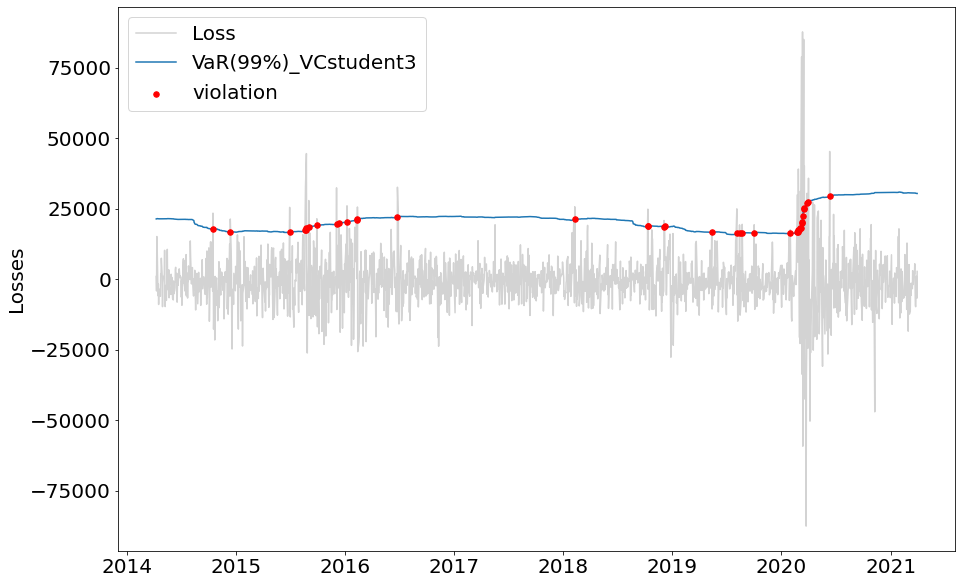

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(Loss_dist[0:1741],label='Loss',color='lightgray', zorder=1) #2014-4-8/2021-3-31
plt.plot(vc_roll_stu_daily['VaR_99'][1:1742],label='VaR(99%)_VCstudent3', zorder=2)
plt.scatter(vc_roll_stu_daily.VaR_99[1:1742][Loss_dist[0:1741]>vc_roll_stu_daily.VaR_99[1:1742]].index,
            vc_roll_stu_daily.VaR_99[1:1742][Loss_dist[0:1741]>vc_roll_stu_daily.VaR_99[1:1742]].values,
            marker='o',c='r',s=30, label='violation', zorder=3)
plt.ylabel('Losses',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', prop={'size': 20})
plt.savefig('Violation_VC_student_99',dpi=400)
plt.show()

In [ ]:
# hs violation per year-97.5%
Loss_dist=L.loss[750:]*1000000 #2014-4-8/2021-4-1
hs_violation=[]
for i in range(0,int(len(Loss_dist)/250)):
    bool_list = [Loss_dist[j]>hs_roll_daily['VaR_975'][j+1] for j in range(i*250,(i+1)*250)]
    index = np.where(bool_list)[0]
    count = len(index)
    #print(i,":",count)
    hs_violation.append(count)
bool_list = [Loss_dist[j]>hs_roll_daily['VaR_975'][j+1] for j in range(1500,1741)]
index = np.where(bool_list)[0]
count = len(index)
hs_violation.append(count)
print(hs_violation)

[4, 19, 3, 5, 5, 24, 5]


In [ ]:
stats.binom_test(np.sum(hs_violation),n=1741,p=0.025)

0.0020301634111326503

In [ ]:
# hs violation per year-99%
Loss_dist=L.loss[750:]*1000000 #2014-4-8/2021-4-1
hs_violation=[]
for i in range(0,int(len(Loss_dist)/250)):
    bool_list = [Loss_dist[j]>hs_roll_daily['VaR_99'][j+1] for j in range(i*250,(i+1)*250)]
    index = np.where(bool_list)[0]
    count = len(index)
    #print(i,":",count)
    hs_violation.append(count)
bool_list = [Loss_dist[j]>hs_roll_daily['VaR_99'][j+1] for j in range(1500,1741)]
index = np.where(bool_list)[0]
count = len(index)
hs_violation.append(count)
print(hs_violation)

[2, 10, 1, 1, 1, 15, 1]


In [ ]:
stats.binom_test(np.sum(hs_violation),n=1741,p=0.01)

0.002432486432998378

In [ ]:
hs_es_true=[]
hs_es_esti=[]
for i in range(0,int(len(Loss_dist)/250)):
    true_ES= np.mean(Loss_dist[i*250:(i+1)*250][Loss_dist[i*250:(i+1)*250]>hs_roll_daily.VaR_975[1+i*250:1+(i+1)*250]])
    hs_es_true.append(true_ES)
    estimate_ES= np.mean(hs_roll_daily.ES_975[1+i*250:1+(i+1)*250])
    hs_es_esti.append(estimate_ES)
true_ES= np.mean(Loss_dist[1500:1741][Loss_dist[1500:1741]>hs_roll_daily.VaR_975[1501:1742]])
hs_es_true.append(true_ES)
estimate_ES= np.mean(hs_roll_daily.ES_975[1501:1742])
hs_es_esti.append(estimate_ES)
print(hs_es_true)
print(hs_es_esti)

[18905.752755628335, 22831.14311997066, 24058.88276838216, 20321.49875847693, 20598.506136623197, 31935.642856575967, 28134.025616112376]
[20394.653466387554, 20331.441768003555, 24836.684220647745, 24810.922212266156, 22348.641173034248, 20829.207306931254, 38336.332677841725]


In [ ]:
stats.kstest(hs_es_true,hs_es_esti)

KstestResult(statistic=0.2857142857142857, pvalue=0.9627039627039629)

In [ ]:
hs_es_true=[]
hs_es_esti=[]
for i in range(0,int(len(Loss_dist)/250)):
    true_ES= np.mean(Loss_dist[i*250:(i+1)*250][Loss_dist[i*250:(i+1)*250]>hs_roll_daily.VaR_99[1+i*250:1+(i+1)*250]])
    hs_es_true.append(true_ES)
    estimate_ES= np.mean(hs_roll_daily.ES_99[1+i*250:1+(i+1)*250])
    hs_es_esti.append(estimate_ES)
true_ES= np.mean(Loss_dist[1500:1741][Loss_dist[1500:1741]>hs_roll_daily.VaR_99[1501:1742]])
hs_es_true.append(true_ES)
estimate_ES= np.mean(hs_roll_daily.ES_99[1501:1742])
hs_es_esti.append(estimate_ES)
print(hs_es_true)
print(hs_es_esti)

[22404.092219425154, 27546.631551750448, 32638.226610469854, 25710.80674262765, 24860.261270774772, 39946.31704941628, 45332.17629613117]
[25464.592215835262, 25619.9633987292, 30719.6882820348, 30962.98718838164, 27186.562913822665, 25320.940453866184, 55151.98960382323]


In [ ]:
stats.kstest(hs_es_true,hs_es_esti)

KstestResult(statistic=0.2857142857142857, pvalue=0.9627039627039629)

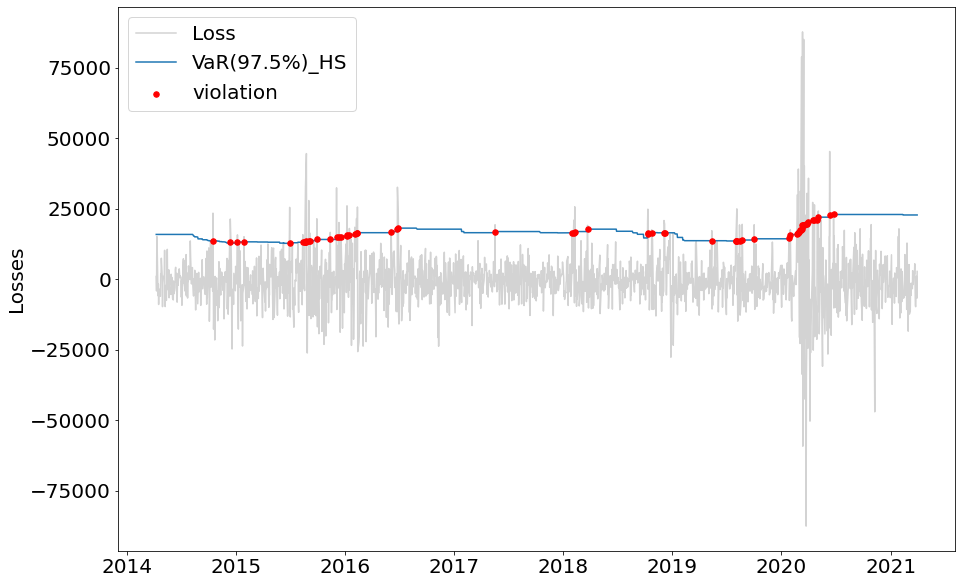

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(Loss_dist[0:1741],label='Loss',color='lightgray', zorder=1) #2014-4-8/2021-3-31
plt.plot(hs_roll_daily['VaR_975'][1:1742],label='VaR(97.5%)_HS', zorder=2)
plt.scatter(hs_roll_daily.VaR_975[1:1742][Loss_dist[0:1741]>hs_roll_daily.VaR_975[1:1742]].index,
            hs_roll_daily.VaR_975[1:1742][Loss_dist[0:1741]>hs_roll_daily.VaR_975[1:1742]].values,
            marker='o',c='r',s=30, label='violation', zorder=3)
plt.ylabel('Losses',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', prop={'size': 20})
plt.savefig('Violation_HS_975',dpi=400)
plt.show()

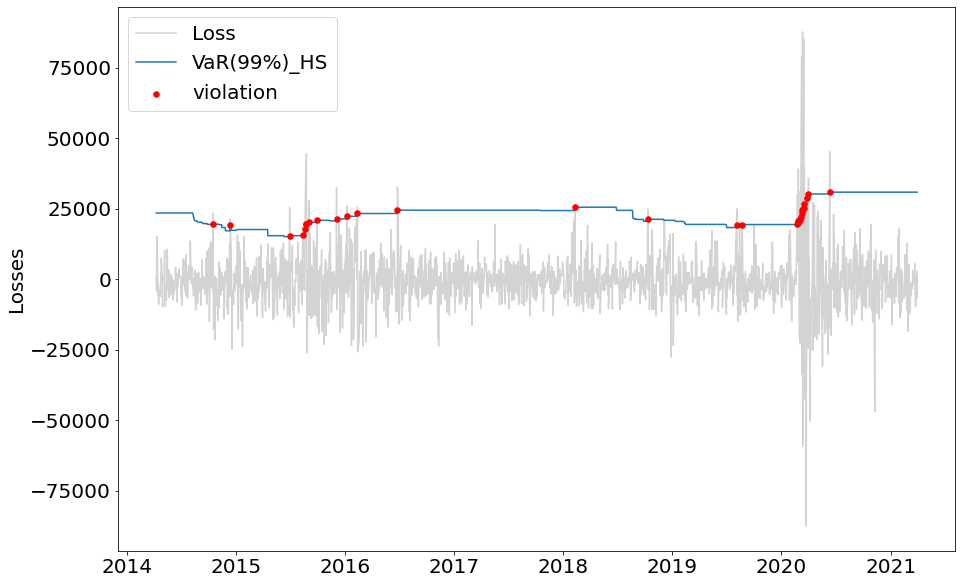

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(Loss_dist[0:1741],label='Loss',color='lightgray', zorder=1) #2014-4-8/2021-3-31
plt.plot(hs_roll_daily['VaR_99'][1:1742],label='VaR(99%)_HS', zorder=2)
plt.scatter(hs_roll_daily.VaR_99[1:1742][Loss_dist[0:1741]>hs_roll_daily.VaR_99[1:1742]].index,
            hs_roll_daily.VaR_99[1:1742][Loss_dist[0:1741]>hs_roll_daily.VaR_99[1:1742]].values,
            marker='o',c='r',s=30, label='violation', zorder=3)
plt.ylabel('Losses',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', prop={'size': 20})
plt.savefig('Violation_HS_99',dpi=400)
plt.show()

In [ ]:
# fhs violation per year-97.5%
Loss_dist=L.loss[750:]*1000000 #2014-4-8/2021-4-1
fhs_violation=[]
for i in range(0,int(len(Loss_dist)/250)):
    bool_list = [Loss_dist[j+1]>fhs_roll_daily['VaR_975'][j] for j in range(i*250,(i+1)*250)]
    index = np.where(bool_list)[0]
    count = len(index)
    #print(i,":",count)
    fhs_violation.append(count)
bool_list = [Loss_dist[j+1]>fhs_roll_daily['VaR_975'][j] for j in range(1500,1741)]
index = np.where(bool_list)[0]
count = len(index)
fhs_violation.append(count)
print(fhs_violation)

[6, 7, 4, 10, 9, 22, 7]


In [ ]:
stats.binom_test(np.sum(fhs_violation),n=1741,p=0.025)

0.0020301634111326503

In [ ]:
# fhs violation per year-99%
Loss_dist=L.loss[750:]*1000000 #2014-4-8/2021-4-1
fhs_violation=[]
for i in range(0,int(len(Loss_dist)/250)):
    bool_list = [Loss_dist[j+1]>fhs_roll_daily['VaR_99'][j] for j in range(i*250,(i+1)*250)]
    index = np.where(bool_list)[0]
    count = len(index)
    #print(i,":",count)
    fhs_violation.append(count)
bool_list = [Loss_dist[j+1]>fhs_roll_daily['VaR_99'][j] for j in range(1500,1741)]
index = np.where(bool_list)[0]
count = len(index)
fhs_violation.append(count)
print(fhs_violation)

[3, 5, 2, 7, 6, 17, 2]


In [ ]:
stats.binom_test(np.sum(fhs_violation),n=1741,p=0.01)

3.804996687492206e-07

In [ ]:
fhs_es_true=[]
fhs_es_esti=[]
for i in range(0,int(len(Loss_dist)/250)):
    true_ES= np.mean(Loss_dist[1+i*250:1+(i+1)*250][Loss_dist[1+i*250:1+(i+1)*250]>fhs_roll_daily.VaR_975[i*250:(i+1)*250]])
    fhs_es_true.append(true_ES)
    estimate_ES= np.mean(fhs_roll_daily.ES_975[i*250:(i+1)*250])
    fhs_es_esti.append(estimate_ES)
true_ES= np.mean(Loss_dist[1501:1742][Loss_dist[1501:1742]>fhs_roll_daily.VaR_975[1500:1741]])
fhs_es_true.append(true_ES)
estimate_ES= np.mean(fhs_roll_daily.ES_975[1500:1741])
fhs_es_esti.append(estimate_ES)
print(fhs_es_true)
print(fhs_es_esti)

[15779.133808647952, 30043.2579867896, 21460.997119260323, 16177.040650222834, 17180.306923617765, 27789.653175439522, 20962.792334205064]
[18571.33208427615, 27264.613083346678, 17124.278647143503, 13731.806396807095, 16381.525293673962, 21844.47681753305, 27254.08688228088]


In [ ]:
stats.kstest(fhs_es_true,fhs_es_esti)

KstestResult(statistic=0.2857142857142857, pvalue=0.9627039627039629)

In [ ]:
fhs_es_true=[]
fhs_es_esti=[]
for i in range(0,int(len(Loss_dist)/250)):
    true_ES= np.mean(Loss_dist[1+i*250:1+(i+1)*250][Loss_dist[1+i*250:1+(i+1)*250]>fhs_roll_daily.VaR_99[i*250:(i+1)*250]])
    fhs_es_true.append(true_ES)
    estimate_ES= np.mean(fhs_roll_daily.ES_99[i*250:(i+1)*250])
    fhs_es_esti.append(estimate_ES)
true_ES= np.mean(Loss_dist[1501:1742][Loss_dist[1501:1742]>fhs_roll_daily.VaR_99[1500:1741]])
fhs_es_true.append(true_ES)
estimate_ES= np.mean(fhs_roll_daily.ES_99[1500:1741])
fhs_es_esti.append(estimate_ES)
print(fhs_es_true)
print(fhs_es_esti)

[19462.552855083504, 31728.09105494276, 23152.783391182333, 18652.319149624665, 17350.059117231365, 30646.057434094262, 31606.75795252771]
[21773.895273129914, 31637.63460448373, 19638.81207865496, 16426.55836945536, 20043.71601600388, 25884.428439597577, 31857.952675065506]


In [ ]:
stats.kstest(fhs_es_true,fhs_es_esti)

KstestResult(statistic=0.2857142857142857, pvalue=0.9627039627039629)

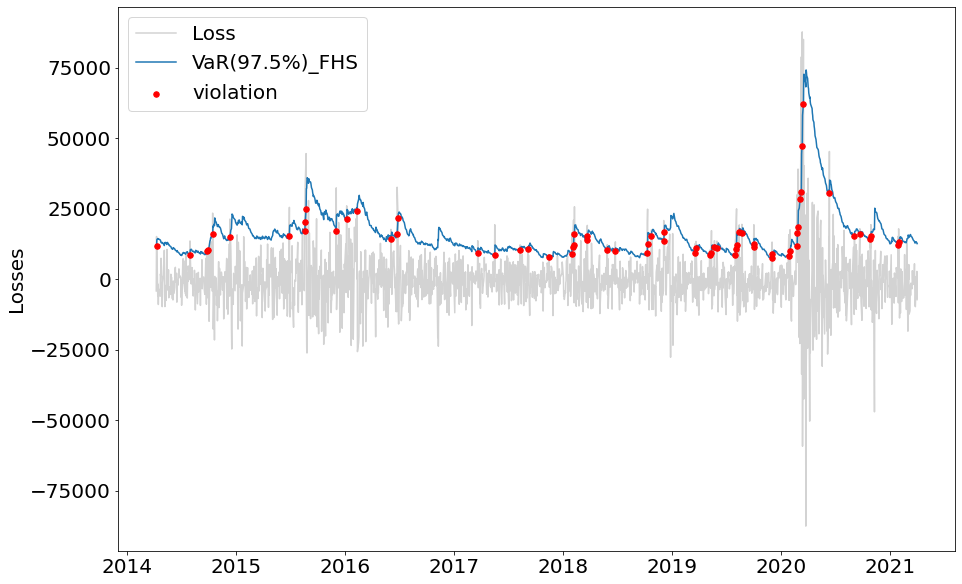

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(Loss_dist[1:1742],label='Loss',color='lightgray', zorder=1) #2014-4-9/2021-4-1
plt.plot(fhs_roll_daily['VaR_975'][0:1741],label='VaR(97.5%)_FHS', zorder=2)
plt.scatter(fhs_roll_daily.VaR_975[0:1741][Loss_dist[1:1742]>fhs_roll_daily.VaR_975[0:1741]].index,
            fhs_roll_daily.VaR_975[0:1741][Loss_dist[1:1742]>fhs_roll_daily.VaR_975[0:1741]].values,
            marker='o',c='r',s=30, label='violation', zorder=3)
plt.ylabel('Losses',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', prop={'size': 20})
plt.savefig('Violation_FHS_975',dpi=400)
plt.show()

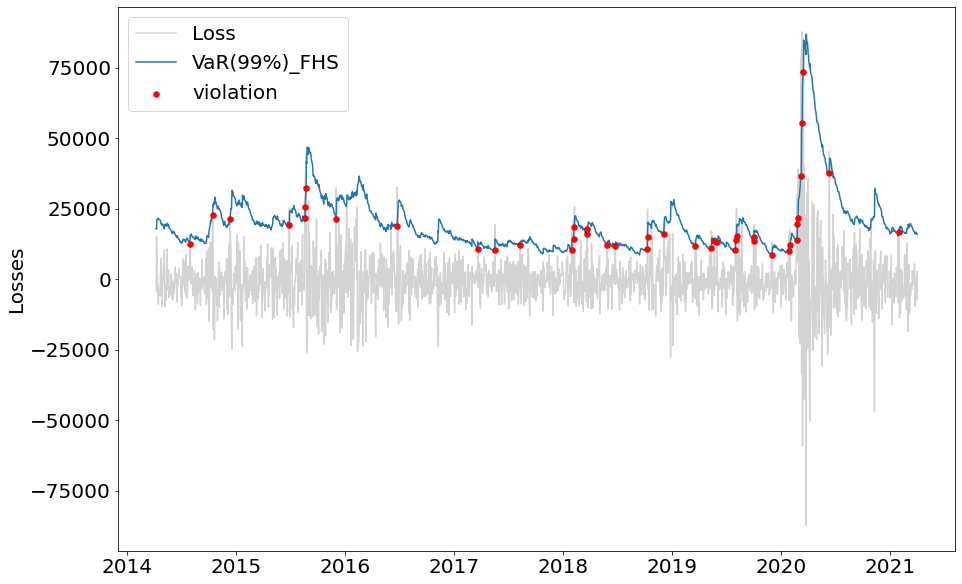

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(Loss_dist[1:1742],label='Loss',color='lightgray', zorder=1) #2014-4-9/2021-4-1
plt.plot(fhs_roll_daily['VaR_99'][0:1741],label='VaR(99%)_FHS', zorder=2)
plt.scatter(fhs_roll_daily.VaR_99[0:1741][Loss_dist[1:1742]>fhs_roll_daily.VaR_99[0:1741]].index,
            fhs_roll_daily.VaR_99[0:1741][Loss_dist[1:1742]>fhs_roll_daily.VaR_99[0:1741]].values,
            marker='o',c='r',s=30, label='violation', zorder=3)
plt.ylabel('Losses',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', prop={'size': 20})
plt.savefig('Violation_FHS_99',dpi=400)
plt.show()

In [ ]:
# ccc violation per year-97.5%
Loss_dist=L.loss[750:]*1000000 #2014-4-8/2021-4-1
ccc_violation=[]
for i in range(0,int(len(Loss_dist)/250)):
    bool_list = [Loss_dist[j]>garchresult['VaR_975'][j] for j in range(i*250,(i+1)*250)]
    index = np.where(bool_list)[0]
    count = len(index)
    #print(i,":",count)
    ccc_violation.append(count)
bool_list = [Loss_dist[j]>garchresult['VaR_975'][j] for j in range(1500,1742)]
index = np.where(bool_list)[0]
count = len(index)
ccc_violation.append(count)
print(ccc_violation)

[5, 15, 3, 7, 8, 18, 6]


In [ ]:
stats.binom_test(np.sum(ccc_violation),n=1742,p=0.025)

0.0070285113439739096

In [ ]:
# ccc violation per year-97.5%
Loss_dist=L.loss[750:]*1000000 #2014-4-8/2021-4-1
ccc_violation=[]
for i in range(0,int(len(Loss_dist)/250)):
    bool_list = [Loss_dist[j]>garchresult['VaR_99'][j] for j in range(i*250,(i+1)*250)]
    index = np.where(bool_list)[0]
    count = len(index)
    #print(i,":",count)
    ccc_violation.append(count)
bool_list = [Loss_dist[j]>garchresult['VaR_99'][j] for j in range(1500,1742)]
index = np.where(bool_list)[0]
count = len(index)
ccc_violation.append(count)
print(ccc_violation)

[3, 8, 3, 5, 3, 13, 3]


In [ ]:
stats.binom_test(np.sum(ccc_violation),n=1742,p=0.01)

1.616936591009333e-05

In [ ]:
ccc_es_true=[]
ccc_es_esti=[]
for i in range(0,int(len(Loss_dist)/250)):
    true_ES= np.mean(Loss_dist[i*250:(i+1)*250][Loss_dist[i*250:(i+1)*250]>garchresult.VaR_975[i*250:(i+1)*250]])
    ccc_es_true.append(true_ES)
    estimate_ES= np.mean(garchresult.ES_975[i*250:(i+1)*250])
    ccc_es_esti.append(estimate_ES)
true_ES= np.mean(Loss_dist[1500:1742][Loss_dist[1500:1742]>garchresult.VaR_975[1500:1742]])
ccc_es_true.append(true_ES)
estimate_ES= np.mean(garchresult.ES_975[1500:1742])
ccc_es_esti.append(estimate_ES)
print(ccc_es_true)
print(ccc_es_esti)

[17854.29427830286, 24078.998623818243, 21324.44190644186, 18652.319149624665, 17650.119139500875, 26368.846468300864, 22777.829468465487]
[15602.233945852462, 21414.757814968667, 16765.793797775907, 15194.329408305424, 15857.646289723938, 22765.56327628382, 24781.50249588441]


In [ ]:
stats.kstest(ccc_es_true,ccc_es_esti)

KstestResult(statistic=0.5714285714285714, pvalue=0.21212121212121213)

In [ ]:
ccc_es_true=[]
ccc_es_esti=[]
for i in range(0,int(len(Loss_dist)/250)):
    true_ES= np.mean(Loss_dist[i*250:(i+1)*250][Loss_dist[i*250:(i+1)*250]>garchresult.VaR_99[i*250:(i+1)*250]])
    ccc_es_true.append(true_ES)
    estimate_ES= np.mean(garchresult.ES_99[i*250:(i+1)*250])
    ccc_es_esti.append(estimate_ES)
true_ES= np.mean(Loss_dist[1500:1742][Loss_dist[1500:1742]>garchresult.VaR_99[1500:1742]])
ccc_es_true.append(true_ES)
estimate_ES= np.mean(garchresult.ES_99[1500:1742])
ccc_es_esti.append(estimate_ES)
print(ccc_es_true)
print(ccc_es_esti)

[19462.552855083504, 27741.190320862064, 21324.44190644186, 19854.79548629591, 21963.97742349906, 30065.86447522368, 25960.409673320723]
[17836.228681505247, 24464.551107759602, 19161.423712556698, 17371.18437564433, 18122.41390799999, 25996.73694281793, 28293.102838995877]


In [ ]:
stats.kstest(ccc_es_true,ccc_es_esti)

KstestResult(statistic=0.5714285714285714, pvalue=0.21212121212121213)

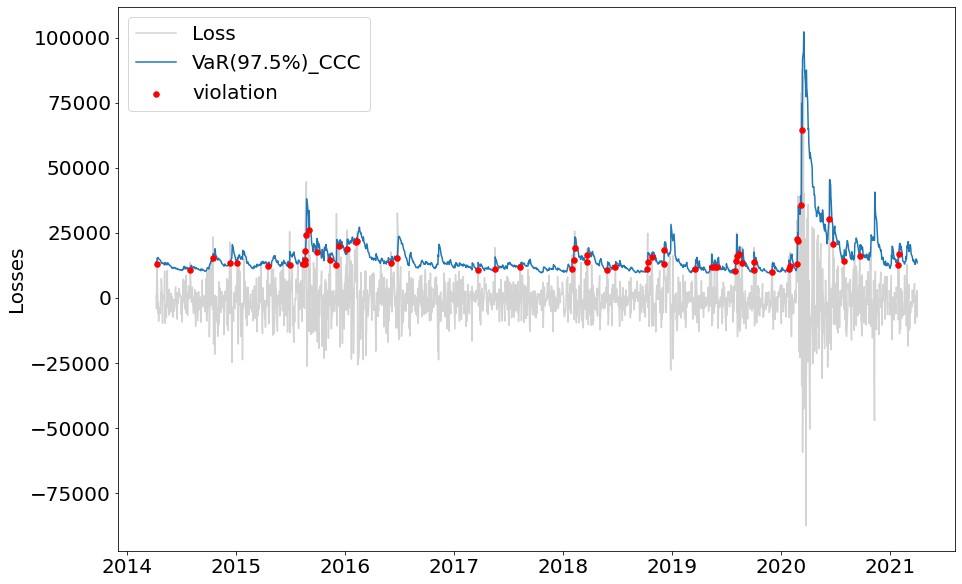

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(Loss_dist[0:1742],label='Loss',color='lightgray', zorder=1) #2014-4-8/2021-4-1
plt.plot(garchresult['VaR_975'][0:1742],label='VaR(97.5%)_CCC', zorder=2)
plt.scatter(garchresult.VaR_975[0:1742][Loss_dist[0:1742]>garchresult.VaR_975[0:1742]].index,
            garchresult.VaR_975[0:1742][Loss_dist[0:1742]>garchresult.VaR_975[0:1742]].values,
            marker='o',c='r',s=30, label='violation', zorder=3)
plt.ylabel('Losses',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', prop={'size': 20})
plt.savefig('Violation_CCC_975',dpi=400)
plt.show()

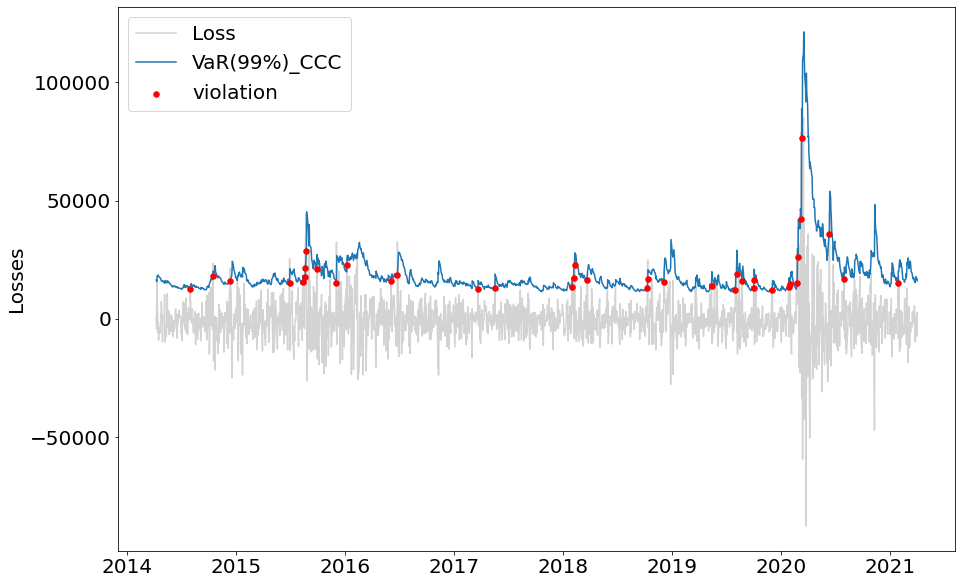

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(Loss_dist[0:1742],label='Loss',color='lightgray', zorder=1) #2014-4-8/2021-4-1
plt.plot(garchresult['VaR_99'][0:1742],label='VaR(99%)_CCC', zorder=2)
plt.scatter(garchresult.VaR_99[0:1742][Loss_dist[0:1742]>garchresult.VaR_99[0:1742]].index,
            garchresult.VaR_99[0:1742][Loss_dist[0:1742]>garchresult.VaR_99[0:1742]].values,
            marker='o',c='r',s=30, label='violation', zorder=3)
plt.ylabel('Losses',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best', prop={'size': 20})
plt.savefig('Violation_CCC_99',dpi=400)
plt.show()

In [ ]:
L.iloc[82:92] #first period

,DJ,SP500,AEX,bond,y,loss
Date,,,,,,
2011-08-02,-0.024606,-0.021811,-0.014242,-0.00040,1.426,0.015120
2011-08-03,-0.002340,-0.004254,-0.029525,-0.00012,1.414,0.008963
2011-08-04,-0.042036,-0.033737,-0.032184,-0.00156,1.258,0.026906
2011-08-05,-0.028646,-0.012833,-0.015071,-0.00043,1.215,0.014107
2011-08-08,-0.104927,-0.061579,-0.044823,-0.00108,1.107,0.051072
2011-08-09,0.060686,0.032796,0.012938,0.00070,1.177,-0.027395
2011-08-10,-0.076029,-0.031423,-0.034665,-0.00193,0.984,0.035047
2011-08-11,0.063893,0.040394,0.019713,0.00085,1.069,-0.031979
2011-08-12,-0.012313,0.004827,0.031707,0.00018,1.087,-0.006238


In [ ]:
L.iloc[1087:1097] #second period

,DJ,SP500,AEX,bond,y,loss
Date,,,,,,
2015-08-17,-0.001732,0.007542,0.000865,0.00021,-0.132,-0.001730
2015-08-18,0.003471,0.002800,0.009881,0.00000,-0.132,-0.004054
2015-08-19,-0.022682,-0.017142,-0.020607,0.00004,-0.128,0.014944
2015-08-20,-0.040174,-0.032327,-0.021694,-0.00011,-0.139,0.023188
2015-08-21,-0.053375,-0.045360,-0.036144,0.00000,-0.139,0.032954
2015-08-24,-0.069782,-0.060291,-0.053784,-0.00005,-0.144,0.044580
2015-08-25,-0.008589,-0.004711,0.039708,0.00031,-0.113,-0.006892
2015-08-26,0.055571,0.055986,-0.018373,0.00003,-0.110,-0.024139
2015-08-27,0.039219,0.030213,0.033555,-0.00006,-0.116,-0.026185


In [ ]:
L.iloc[2222:2237] #third period

,DJ,SP500,AEX,bond,y,loss
Date,,,,,,
2020-03-05,-0.075702,-0.043895,-0.009349,-0.00003,-0.786,0.031289
2020-03-06,-0.038481,-0.021196,-0.039218,0.00011,-0.775,0.024260
2020-03-09,-0.161572,-0.093350,-0.079557,-0.00086,-0.861,0.078905
2020-03-10,0.078110,0.063086,-0.012221,0.00049,-0.812,-0.033684
2020-03-11,-0.064314,-0.049127,-0.001115,-0.00020,-0.832,0.027878
2020-03-12,-0.169191,-0.092463,-0.113758,0.00043,-0.789,0.087759
2020-03-13,0.125624,0.095896,0.001734,0.00073,-0.716,-0.059249
2020-03-16,-0.195620,-0.134561,-0.037857,0.00030,-0.686,0.085099
2020-03-17,0.070679,0.074999,0.017812,0.00103,-0.583,-0.042536


In [ ]:
# currencies moving by 10% up for euro/usd
data_stress_test1= pd.DataFrame(columns=['DJ','SP500','AEX','bond','euro_usd'])
data_stress_test1['DJ']=data['DJ']
data_stress_test1['SP500']=data['SP500']
data_stress_test1['AEX']=data['AEX']
data_stress_test1['bond']=data['bond']
data_stress_test1['euro_usd']= pd.concat([data['euro_usd'][0:82],data['euro_usd'][82:92]*1.1,data['euro_usd'][92:1087],data['euro_usd'][1087:1097]*1.1,data['euro_usd'][1097:2222],data['euro_usd'][2222:2237]*1.1,data['euro_usd'][2237:2493]])

In [ ]:
data_stress_test1

,DJ,SP500,AEX,bond,euro_usd
Date,,,,,
2011-04-01,345.464128,936.272925,369.45,2.208,1.4231
2011-04-04,348.586697,937.188862,369.01,2.203,1.4222
2011-04-05,346.220910,936.954229,368.96,2.199,1.4223
2011-04-06,347.729017,931.793763,369.64,2.214,1.4333
2011-04-07,345.155201,932.263702,367.39,2.211,1.4304
...,...,...,...,...,...
2021-03-26,729.103086,3369.396406,696.62,-0.714,1.1796
2021-03-29,723.193334,3376.203027,697.94,-0.704,1.1762
2021-03-30,738.543623,3379.332423,701.12,-0.685,1.1714


In [ ]:
data_stress_test1=data_stress_test1.dropna()
data_stress_test1['DJ']=data_stress_test1['DJ']/data_stress_test1['euro_usd']
data_stress_test1['SP500']=data_stress_test1['SP500']/data_stress_test1['euro_usd']

In [ ]:
# Log return
L_stress_test1=pd.DataFrame(columns=['DJ','SP500','AEX','bond'])
L_stress_test1['DJ']=np.log(data_stress_test1['DJ']).diff() # log return
L_stress_test1['SP500']=np.log(data_stress_test1['SP500']).diff()
L_stress_test1['AEX']=np.log(data_stress_test1['AEX']).diff()
L_stress_test1['bond']=data_stress_test1['bond'].diff() 
L_stress_test1['bond']=L_stress_test1['bond']/100 #change yield
L_stress_test1['y']=data_stress_test1['bond']
L_stress_test1=L_stress_test1.dropna() # remove first row
# compute everyday portfolio loss, last column
L_stress_test1['loss']=L_stress_test1.apply(lambda r: 0.25*(1-np.exp(r.DJ))+\
                            0.25*(1-np.exp(r.SP500))+\
                            0.25*(1-np.exp(r.AEX))\
                           -0.25*(1-np.exp(-r.bond))+\
                            0.25*r.y / 25000,
                            axis=1) # without time to maturity
L_stress_test1

,DJ,SP500,AEX,bond,y,loss
Date,,,,,,
2011-04-04,0.009631,0.001610,-0.001192,-0.00005,2.203,-0.002490
2011-04-05,-0.006880,-0.000321,-0.000136,-0.00004,2.199,0.001860
2011-04-06,-0.003358,-0.013227,0.001841,0.00015,2.214,0.003647
2011-04-07,-0.005404,0.002530,-0.006106,-0.00003,2.211,0.002266
2011-04-08,-0.037788,-0.028609,-0.001226,0.00083,2.294,0.016443
...,...,...,...,...,...,...
2021-03-26,0.005851,0.011061,0.016340,0.00004,-0.714,-0.008383
2021-03-29,-0.005252,0.004905,0.001893,0.00010,-0.704,-0.000425
2021-03-30,0.025093,0.005016,0.004546,0.00019,-0.685,-0.008803


In [ ]:
print(L['loss'][-1])
print(L_stress_test1['loss'][-1])

-0.00724245565450307
-0.005229875710621971


In [ ]:
# currencies moving by 10% down for euro/usd
data_stress_test2= pd.DataFrame(columns=['DJ','SP500','AEX','bond','euro_usd'])
data_stress_test2['DJ']=data['DJ']
data_stress_test2['SP500']=data['SP500']
data_stress_test2['AEX']=data['AEX']
data_stress_test2['bond']=data['bond']
data_stress_test2['euro_usd']= pd.concat([data['euro_usd'][0:82],data['euro_usd'][82:92]*0.9,data['euro_usd'][92:1087],data['euro_usd'][1087:1097]*0.9,data['euro_usd'][1097:2222],data['euro_usd'][2222:2237]*0.9,data['euro_usd'][2237:2493]])

In [ ]:
data_stress_test2=data_stress_test2.dropna()
data_stress_test2['DJ']=data_stress_test2['DJ']/data_stress_test2['euro_usd']
data_stress_test2['SP500']=data_stress_test2['SP500']/data_stress_test2['euro_usd']

In [ ]:
# Log return
L_stress_test2=pd.DataFrame(columns=['DJ','SP500','AEX','bond'])
L_stress_test2['DJ']=np.log(data_stress_test2['DJ']).diff() # log return
L_stress_test2['SP500']=np.log(data_stress_test2['SP500']).diff()
L_stress_test2['AEX']=np.log(data_stress_test2['AEX']).diff()
L_stress_test2['bond']=data_stress_test2['bond'].diff() 
L_stress_test2['bond']=L_stress_test2['bond']/100 #change yield
L_stress_test2['y']=data_stress_test2['bond']
L_stress_test2=L_stress_test2.dropna() # remove first row
# compute everyday portfolio loss, last column
L_stress_test2['loss']=L_stress_test2.apply(lambda r: 0.25*(1-np.exp(r.DJ))+\
                            0.25*(1-np.exp(r.SP500))+\
                            0.25*(1-np.exp(r.AEX))\
                           -0.25*(1-np.exp(-r.bond))+\
                            0.25*r.y / 25000,
                            axis=1) # without time to maturity
L_stress_test2

,DJ,SP500,AEX,bond,y,loss
Date,,,,,,
2011-04-04,0.009631,0.001610,-0.001192,-0.00005,2.203,-0.002490
2011-04-05,-0.006880,-0.000321,-0.000136,-0.00004,2.199,0.001860
2011-04-06,-0.003358,-0.013227,0.001841,0.00015,2.214,0.003647
2011-04-07,-0.005404,0.002530,-0.006106,-0.00003,2.211,0.002266
2011-04-08,-0.037788,-0.028609,-0.001226,0.00083,2.294,0.016443
...,...,...,...,...,...,...
2021-03-26,0.005851,0.011061,0.016340,0.00004,-0.714,-0.008383
2021-03-29,-0.005252,0.004905,0.001893,0.00010,-0.704,-0.000425
2021-03-30,0.025093,0.005016,0.004546,0.00019,-0.685,-0.008803


In [ ]:
L['loss'][2237:2492]

Date
2020-03-26   -0.025206
2020-03-27    0.030478
2020-03-30   -0.024469
2020-03-31    0.010744
2020-04-01    0.035835
                ...   
2021-03-26   -0.009755
2021-03-29    0.001016
2021-03-30   -0.006732
2021-03-31    0.002774
2021-04-01   -0.007242
Name: loss, Length: 255, dtype: float64

In [ ]:
L_stress_test1['loss'][2235:2492]

Date
2020-03-24   -0.084147
2020-03-25   -0.083489
2020-03-26   -0.018209
2020-03-27    0.035294
2020-03-30   -0.028882
                ...   
2021-03-26   -0.008383
2021-03-29   -0.000425
2021-03-30   -0.008803
2021-03-31    0.003368
2021-04-01   -0.005230
Name: loss, Length: 257, dtype: float64

In [ ]:
L_stress_test2['loss'][2235:2492]

Date
2020-03-24   -0.084147
2020-03-25    0.021232
2020-03-26   -0.018209
2020-03-27    0.035294
2020-03-30   -0.028882
                ...   
2021-03-26   -0.008383
2021-03-29   -0.000425
2021-03-30   -0.008803
2021-03-31    0.003368
2021-04-01   -0.005230
Name: loss, Length: 257, dtype: float64

In [ ]:
print(L['loss'][-1],L['loss'][-2])
print(L_stress_test1['loss'][-1],L_stress_test1['loss'][-2])
print(L_stress_test2['loss'][-1],L_stress_test2['loss'][-2])

-0.00724245565450307 0.0027742805223235764
-0.005229875710621971 0.003368357458682649
-0.005229875710621971 0.003368357458682649


In [ ]:
# interest rate moving by 2% up for bond
data_stress_test3= pd.DataFrame(columns=['DJ','SP500','AEX','bond','euro_usd'])
data_stress_test3['DJ']=data['DJ']
data_stress_test3['SP500']=data['SP500']
data_stress_test3['AEX']=data['AEX']
data_stress_test3['bond']=pd.concat([data['bond'][0:82],data['bond'][82:92]+0.02,data['bond'][92:1087],data['bond'][1087:1097]+0.02,data['bond'][1097:2222],data['bond'][2222:2237]+0.02,data['bond'][2237:2493]])
data_stress_test3['euro_usd']= data['euro_usd']

In [ ]:
data_stress_test3=data_stress_test3.dropna()
data_stress_test3['DJ']=data_stress_test3['DJ']/data_stress_test3['euro_usd']
data_stress_test3['SP500']=data_stress_test3['SP500']/data_stress_test3['euro_usd']

In [ ]:
# Log return
L_stress_test3=pd.DataFrame(columns=['DJ','SP500','AEX','bond'])
L_stress_test3['DJ']=np.log(data_stress_test3['DJ']).diff() # log return
L_stress_test3['SP500']=np.log(data_stress_test3['SP500']).diff()
L_stress_test3['AEX']=np.log(data_stress_test3['AEX']).diff()
L_stress_test3['bond']=data_stress_test3['bond'].diff() 
L_stress_test3['bond']=L_stress_test3['bond']/100 #change yield
L_stress_test3['y']=data_stress_test3['bond']
L_stress_test3=L_stress_test3.dropna() # remove first row
# compute everyday portfolio loss, last column
L_stress_test3['loss']=L_stress_test3.apply(lambda r: 0.25*(1-np.exp(r.DJ))+\
                            0.25*(1-np.exp(r.SP500))+\
                            0.25*(1-np.exp(r.AEX))\
                           -0.25*(1-np.exp(-r.bond))+\
                            0.25*r.y / 25000,
                            axis=1) # without time to maturity
L_stress_test3

,DJ,SP500,AEX,bond,y,loss
Date,,,,,,
2011-04-04,0.009631,0.001610,-0.001192,-0.00005,2.203,-0.002490
2011-04-05,-0.006880,-0.000321,-0.000136,-0.00004,2.199,0.001860
2011-04-06,-0.003358,-0.013227,0.001841,0.00015,2.214,0.003647
2011-04-07,-0.005404,0.002530,-0.006106,-0.00003,2.211,0.002266
2011-04-08,-0.037788,-0.028609,-0.001226,0.00083,2.294,0.016443
...,...,...,...,...,...,...
2021-03-26,0.005851,0.011061,0.016340,0.00004,-0.714,-0.008383
2021-03-29,-0.005252,0.004905,0.001893,0.00010,-0.704,-0.000425
2021-03-30,0.025093,0.005016,0.004546,0.00019,-0.685,-0.008803


In [ ]:
print(L['loss'][-1],L['loss'][-2])
print(L_stress_test1['loss'][-1],L_stress_test1['loss'][-2])
print(L_stress_test2['loss'][-1],L_stress_test2['loss'][-2])
print(L_stress_test3['loss'][-1],L_stress_test3['loss'][-2])

-0.00724245565450307 0.0027742805223235764
-0.005229875710621971 0.003368357458682649
-0.005229875710621971 0.003368357458682649
-0.005229875710621971 0.003368357458682649


In [ ]:
# stock price moving by 20% up 
# data_stress_test4= pd.DataFrame(columns=['DJ','SP500','AEX','bond','euro_usd'])
# data_stress_test4['DJ']=pd.concat([data['DJ'][0:82],data['DJ'][82:92]*1.2,data['DJ'][92:1087],data['DJ'][1087:1097]*1.2,data['DJ'][1097:2222],data['DJ'][2222:2237]*1.2,data['DJ'][2237:2493]])
# data_stress_test4['SP500']=pd.concat([data['SP500'][0:82],data['SP500'][82:92]*1.2,data['SP500'][92:1087],data['SP500'][1087:1097]*1.2,data['SP500'][1097:2222],data['SP500'][2222:2237]*1.2,data['SP500'][2237:2493]])
# data_stress_test4['AEX']=pd.concat([data['AEX'][0:82],data['AEX'][82:92]*1.2,data['AEX'][92:1087],data['AEX'][1087:1097]*1.2,data['AEX'][1097:2222],data['AEX'][2222:2237]*1.2,data['AEX'][2237:2493]])
# data_stress_test4['bond']=data['bond']
# data_stress_test4['euro_usd']= data['euro_usd']
data_stress_test4= pd.DataFrame(columns=['DJ','SP500','AEX','bond','euro_usd'])
data_stress_test4['DJ']=pd.concat([data['DJ'][0:82],data['DJ'][82:92]*1.4,data['DJ'][92:1087],data['DJ'][1087:1097]*1.4,data['DJ'][1097:2222],data['DJ'][2222:2237]*1.4,data['DJ'][2237:2493]])
data_stress_test4['SP500']=data.SP500
data_stress_test4['AEX']=data.AEX
data_stress_test4['bond']=data['bond']
data_stress_test4['euro_usd']= data['euro_usd']


In [ ]:
data_stress_test4=data_stress_test4.dropna()
data_stress_test4['DJ']=data_stress_test4['DJ']/data_stress_test4['euro_usd']
data_stress_test4['SP500']=data_stress_test4['SP500']/data_stress_test4['euro_usd']

In [ ]:
# Log return
L_stress_test4=pd.DataFrame(columns=['DJ','SP500','AEX','bond'])
L_stress_test4['DJ']=np.log(data_stress_test4['DJ']).diff() # log return
L_stress_test4['SP500']=np.log(data_stress_test4['SP500']).diff()
L_stress_test4['AEX']=np.log(data_stress_test4['AEX']).diff()
L_stress_test4['bond']=data_stress_test4['bond'].diff() 
L_stress_test4['bond']=L_stress_test4['bond']/100 #change yield
L_stress_test4['y']=data_stress_test4['bond']
L_stress_test4=L_stress_test4.dropna() # remove first row
# compute everyday portfolio loss, last column
L_stress_test4['loss']=L_stress_test4.apply(lambda r: 0.25*(1-np.exp(r.DJ))+\
                            0.25*(1-np.exp(r.SP500))+\
                            0.25*(1-np.exp(r.AEX))\
                           -0.25*(1-np.exp(-r.bond))+\
                            0.25*r.y / 25000,
                            axis=1) # without time to maturity
L_stress_test4

,DJ,SP500,AEX,bond,y,loss
Date,,,,,,
2011-04-04,0.008998,0.000978,-0.001192,-0.00005,2.203,-0.002172
2011-04-05,-0.006810,-0.000250,-0.000136,-0.00004,2.199,0.001825
2011-04-06,0.004346,-0.005523,0.001841,0.00015,2.214,-0.000188
2011-04-07,-0.007429,0.000504,-0.006106,-0.00003,2.211,0.003276
2011-04-08,-0.025490,-0.016311,-0.001226,0.00083,2.294,0.010458
...,...,...,...,...,...,...
2021-03-26,0.008567,0.013778,0.016340,0.00004,-0.714,-0.009755
2021-03-29,-0.008139,0.002018,0.001893,0.00010,-0.704,0.001016
2021-03-30,0.021004,0.000926,0.004546,0.00019,-0.685,-0.006732


In [ ]:
print(L['loss'][-1],L['loss'][-2])
print(L_stress_test1['loss'][-1],L_stress_test1['loss'][-2])
print(L_stress_test2['loss'][-1],L_stress_test2['loss'][-2])
print(L_stress_test3['loss'][-1],L_stress_test3['loss'][-2])
print(L_stress_test4['loss'][-1],L_stress_test4['loss'][-2])

-0.00724245565450307 0.0027742805223235764
-0.005229875710621971 0.003368357458682649
-0.005229875710621971 0.003368357458682649
-0.005229875710621971 0.003368357458682649
-0.00724245565450307 0.0027742805223235764


In [ ]:
print(L['loss'].sum())
print(L_stress_test1['loss'].sum()/L['loss'].sum())
print(L_stress_test2['loss'].sum()/L['loss'].sum())
print(L_stress_test3['loss'].sum()/L['loss'].sum())
print(L_stress_test4['loss'].sum()/L['loss'].sum())

-0.8625455641791512
1.1710367726939825
1.1761755515590078
1.155619765914834
1.0835354231260983


In [ ]:
print(L['loss'].sum())
print(L_stress_test1['loss'].sum())
print(L_stress_test2['loss'].sum())
print(L_stress_test3['loss'].sum())
print(L_stress_test4['loss'].sum())

-0.8625455641791512
-1.0100725737778635
-1.0145050046931887
-0.9967747029675891
-0.9435692990769099


In [ ]:
#yuhao
stress=data.copy(deep=True) # all in USD

In [ ]:
# DJ up 20%
stress.iloc[82:92,0]=stress.iloc[82:92,0]*1.2
stress.iloc[1087:1097,0]=stress.iloc[1087:1097,0]*1.2
#stress.iloc[1087:1597,0]=stress.iloc[1087:1597,0]*2
stress.iloc[2222:2237,0]=stress.iloc[2222:2237,0]*1.2

In [ ]:
# Log return
Ls=pd.DataFrame(columns=['DJ','SP500','AEX','bond'])
Ls['DJ']=np.log(stress['DJ']).diff() # log return
Ls['SP500']=np.log(stress['SP500']).diff()
Ls['AEX']=np.log(stress['AEX']).diff()
Ls['bond']=stress['bond'].diff() 
Ls['bond']=Ls['bond']/100 #change yield
Ls['y']=stress['bond']
Ls=Ls.dropna() # remove first row
# compute everyday portfolio loss, last column
Ls['loss']=Ls.apply(lambda r: 0.25*(1-np.exp(r.DJ))+\
                            0.25*(1-np.exp(r.SP500))+\
                            0.25*(1-np.exp(r.AEX))\
                           -0.25*(1-np.exp(-r.bond))+\
                            0.25*r.y / 25000,
                            axis=1) # without time to maturity
Ls

,DJ,SP500,AEX,bond,y,loss
Date,,,,,,
2011-04-04,0.008998,0.000978,-0.001192,-0.00005,2.203,-0.002172
2011-04-05,-0.006810,-0.000250,-0.000136,-0.00004,2.199,0.001825
2011-04-06,0.004346,-0.005523,0.001841,0.00015,2.214,-0.000188
2011-04-07,-0.007429,0.000504,-0.006106,-0.00003,2.211,0.003276
2011-04-08,-0.025490,-0.016311,-0.001226,0.00083,2.294,0.010458
...,...,...,...,...,...,...
2021-03-26,0.008567,0.013778,0.016340,0.00004,-0.714,-0.009755
2021-03-29,-0.008139,0.002018,0.001893,0.00010,-0.704,0.001016
2021-03-30,0.021004,0.000926,0.004546,0.00019,-0.685,-0.006732


In [ ]:
Ls.loss.quantile(q=0.99)

0.02607201479984512

In [ ]:
L.loss.quantile(q=0.99)

0.025713009411149325

In [ ]:
tt=stress.DJ ==data.DJ
tt.value_counts()

True     2458
False      35
Name: DJ, dtype: int64

In [ ]:
g=garch(L)
gstress=garch(Ls)

Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/root/venv/lib/python3.7/site-packages/arch/univariate/base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/root/venv/lib/python3.7/site-packages/arch/univariate/base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/root/venv/lib/python3.7/site-packages/arch/univariate/base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/root/venv/lib/python3.7/site-packages/arch/univariate/base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompati

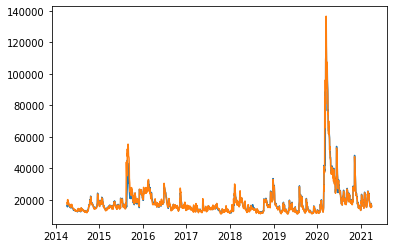

In [ ]:
plt.plot(g.VaR_99)
plt.plot(gstress.VaR_99)

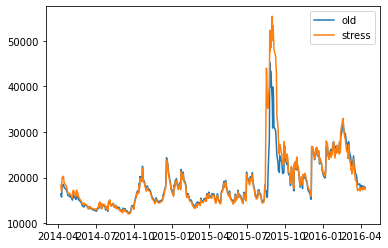

In [ ]:
plt.plot(g.VaR_99[:500],label='old')
plt.plot(gstress.VaR_99[:500],label='stress')
plt.legend()

In [ ]:
sum(L.loss)

-0.8625455641791517

In [ ]:
sum(Ls.loss)

-0.8844220816737862

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=645d3506-ee2c-44c9-a8e9-fa6f8711818a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>